In [34]:
import kde
import simplebinmi
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from collections import OrderedDict
from collections import defaultdict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 检查 GPU 是否可用
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')


# def categorical_cross_entropy(output, target):
#     num_classes = 10
#     epsilon = 1e-8
#     output = torch.clamp(output, epsilon, 1. - epsilon)
#     target = target.float()
#     target = target.reshape(target.shape[0], 1).to(output.device)
#     one_hot_target = (target == torch.arange(num_classes).reshape(1, num_classes).to(output.device)).float()
#     return torch.mean(-torch.sum(one_hot_target * torch.log(output), 1))

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
batch_size = 128 # Reduce batch size

# 数据变换
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Add horizontal flip
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载数据集
train_data = datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor())

# 数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
full_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

class Net(torch.nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Net, self).__init__()
        
        # One convolutional layer followed by batch normalization and ReLU
        self.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)  # 3x3 kernel, 32 filters
        self.bn = nn.BatchNorm2d(32)

        # Pooling layer
        self.avg_pool = nn.AvgPool2d(2)  # 2x2 pooling to reduce spatial size

        # Linear layers
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Flattened size after pooling (32*16*16)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        activations = []
        
        # Convolutional Layer 1
        out = self.conv(x)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        out = self.bn(out)
        out = F.relu(out)
       
        # Pooling Layer
        out = self.avg_pool(out)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        # Flatten before feeding into fully connected layer
        out = out.view(out.size(0), -1)  # Flatten the tensor (batch_size, 32 * 16 * 16)
        
        # Fully Connected Layer 1
        out = self.fc1(out)
        out = F.relu(out)
        
        # Fully Connected Layer 2
        out = self.fc2(out)
        
        activations.append(out.cpu().data.numpy())  # Store final activations
        
        return out, activations

CUDA is available! Training on GPU ...
Files already downloaded and verified


In [35]:
from torchsummary import summary
model = Net(in_channels=3, n_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 使用 torchsummary.summary 打印网络结构
summary(model, input_size=(3, 32, 32))  # 假设输入是3通道的32x32图像

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         AvgPool2d-3           [-1, 32, 16, 16]               0
            Linear-4                  [-1, 128]       1,048,704
            Linear-5                   [-1, 10]           1,290
Total params: 1,050,954
Trainable params: 1,050,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.56
Params size (MB): 4.01
Estimated Total Size (MB): 4.58
----------------------------------------------------------------


In [36]:
class MI_Plate():
    def __init__(self, n_epochs=102, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    def save_activations(self):
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net(in_channels=3, n_classes=10)
        #model.apply(init_weights)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()

        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                #loss = categorical_cross_entropy(output, target)
                loss = loss_fn(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch + 1, train_loss))

            model.eval()

            ######### 每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出 ###########
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
            ############################################################################################
            
            # Log activations for different epochs
            if epoch < 20:
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 100) and (epoch % 5 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)

            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))                  
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array, dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array, dtype=object)

    # Save the results as arrays
        np.save('D:/2023年研究生文件/MI_XMReLU.npy', MI_XM_upper_array)
        np.save('D:/2023年研究生文件/MI_YMReLU.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)   

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.016474
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 10.53%
Epoch: 2 	Training Loss: 0.014995
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 14.21%
Epoch: 3 	Training Loss: 0.014321
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 16.41%
Epoch: 4 	Training Loss: 0.013840
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 17.68%
Epoch: 5 	Training Loss: 0.013463
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 18.40%
Epoch: 6 	Training Loss: 0.013150
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 20.08%
Epoch: 7 	Training Loss: 0.012900
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 19.19%
Epoch: 8 	Training Loss: 0.012676
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 20.18%
Epoch: 9 	Training Loss: 0.012479
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 21.26%
Epoch: 10 	Training Loss: 0.012282
Saving acti

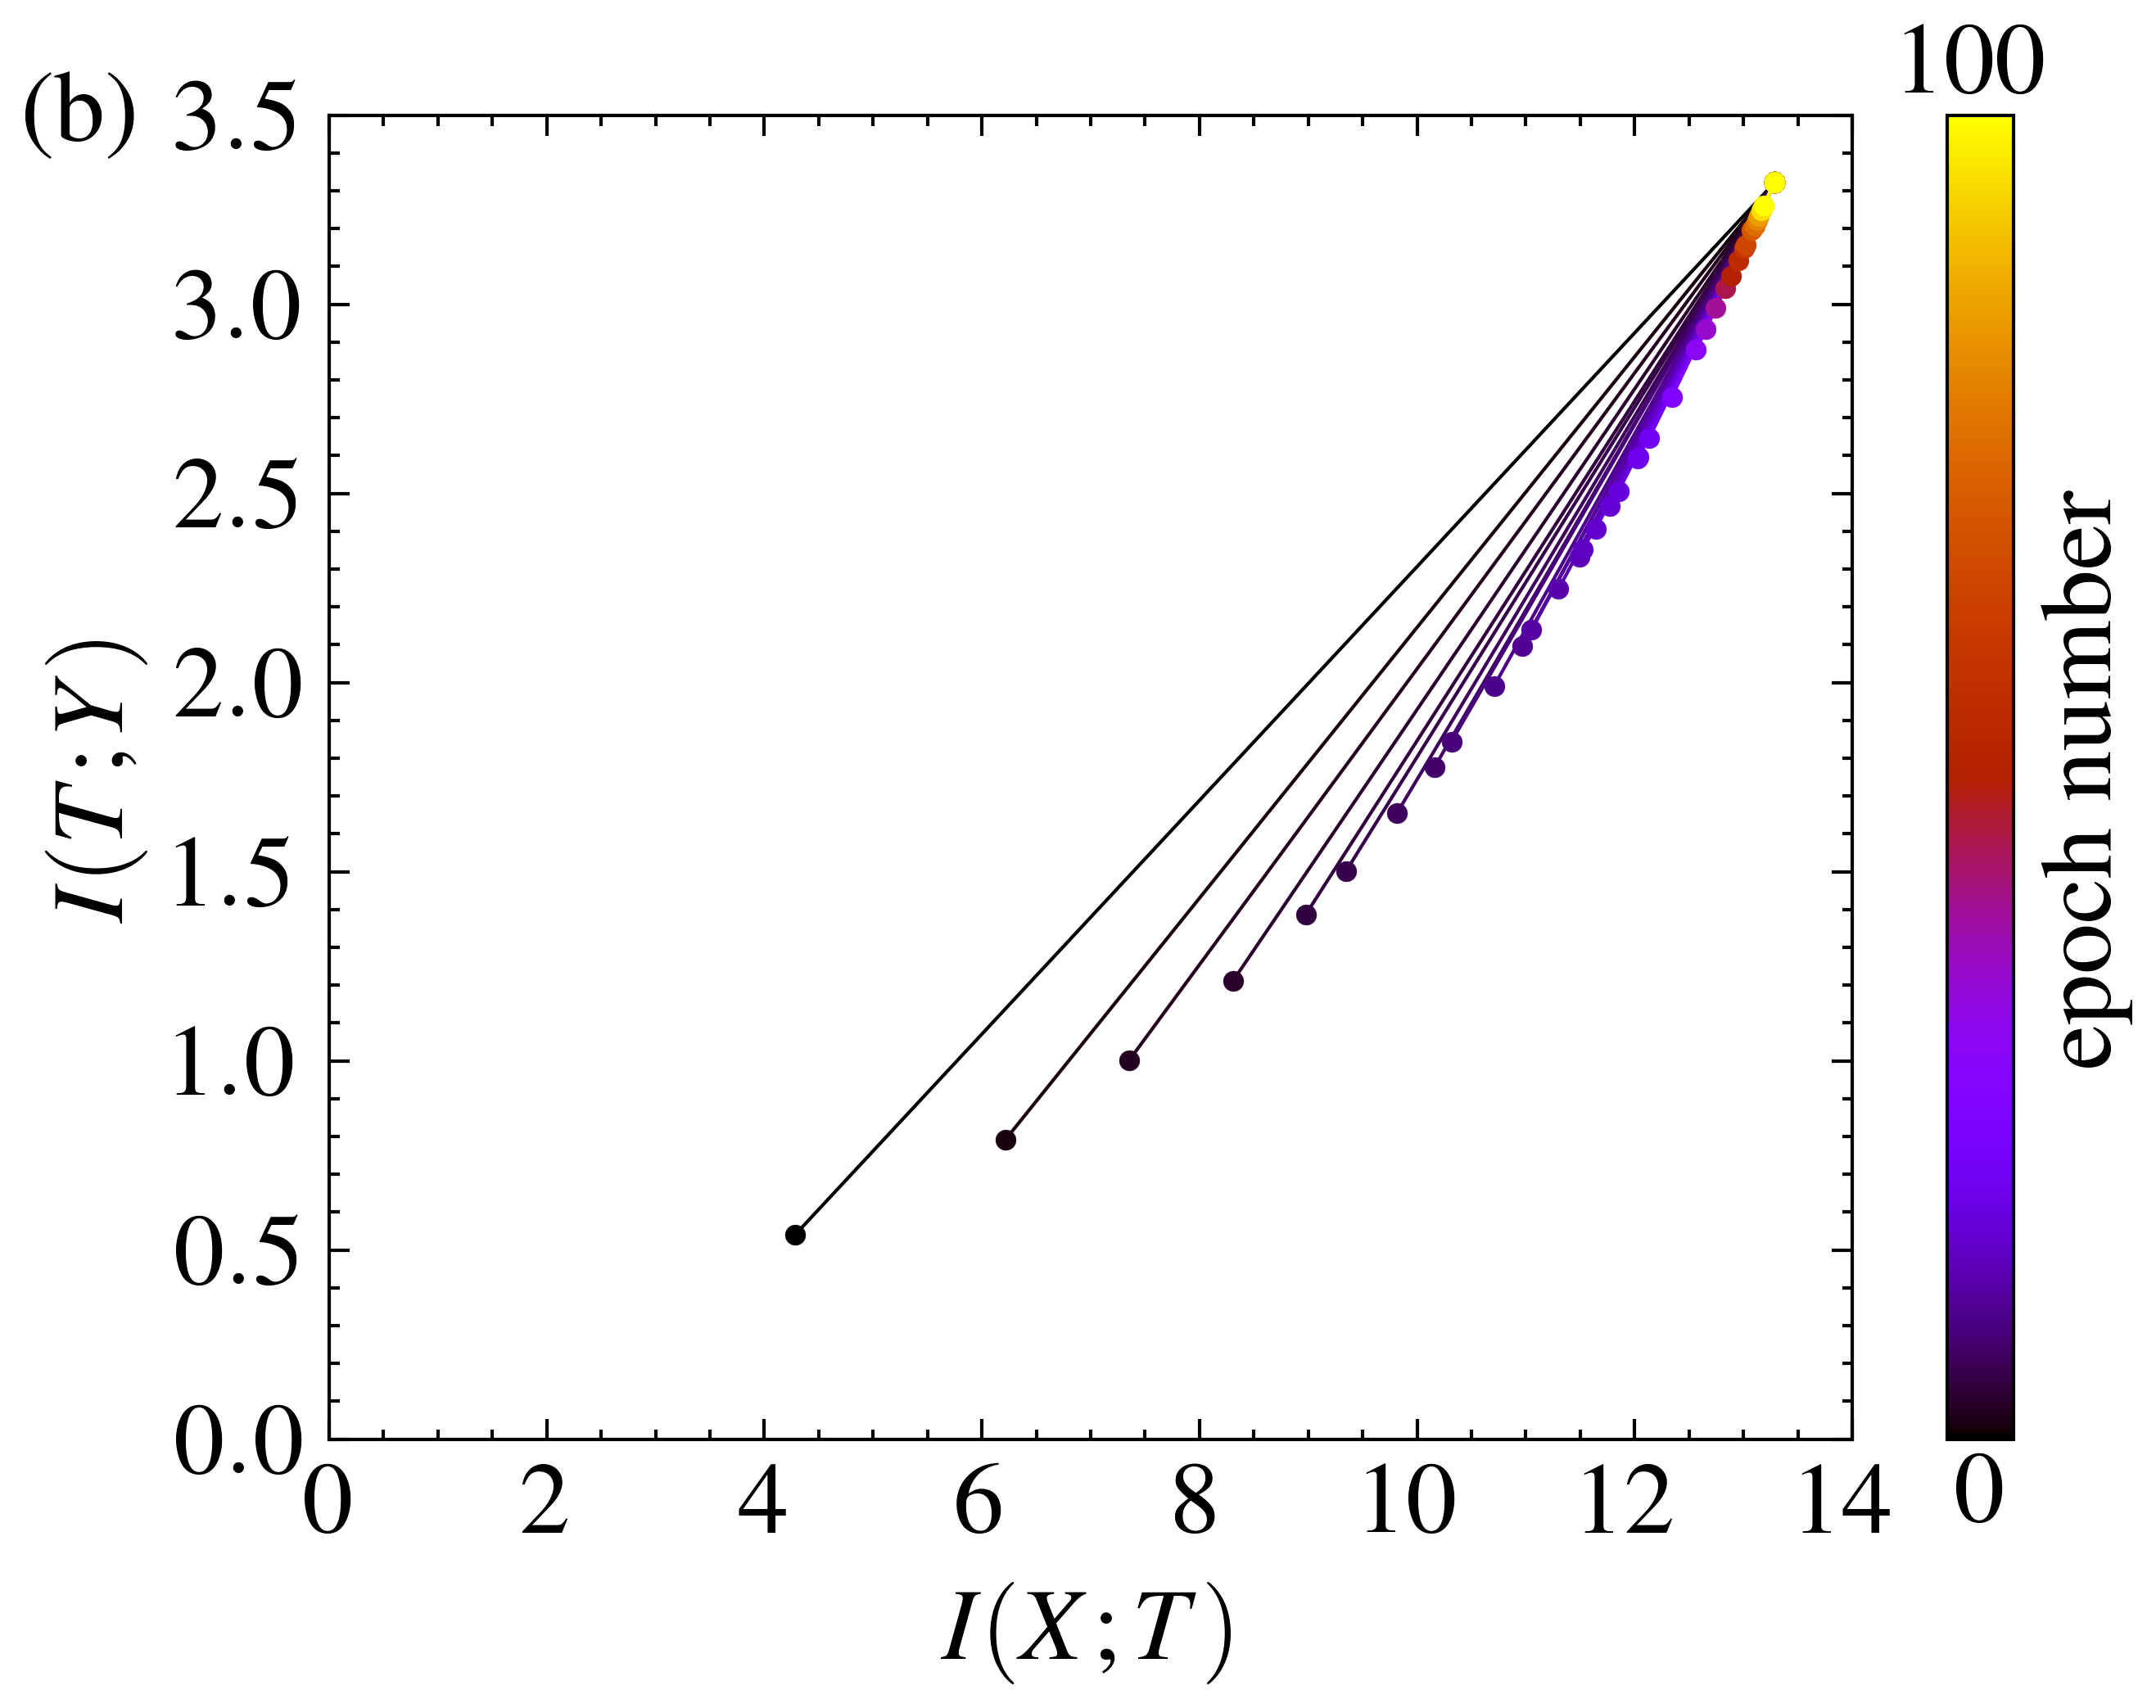

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(0.0, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/2023年研究生文件/Fig9b.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/2023年研究生文件/MI_XMReLU.npy', allow_pickle=True)
ITY_array = np.load('D:/2023年研究生文件/MI_YMReLU.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [7]:
###实验epoch=102

import kde
import simplebinmi
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from collections import OrderedDict
from collections import defaultdict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 检查 GPU 是否可用
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')


# def categorical_cross_entropy(output, target):
#     num_classes = 10
#     epsilon = 1e-8
#     output = torch.clamp(output, epsilon, 1. - epsilon)
#     target = target.float()
#     target = target.reshape(target.shape[0], 1).to(output.device)
#     one_hot_target = (target == torch.arange(num_classes).reshape(1, num_classes).to(output.device)).float()
#     return torch.mean(-torch.sum(one_hot_target * torch.log(output), 1))

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
batch_size = 128 # Reduce batch size

# 数据变换
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Add horizontal flip
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载数据集
train_data = datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor())

# 数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
full_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

import math

class GELU(nn.Module): 
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 可学习参数 sigma

    def forward(self, input):
        x = input * (1 + torch.erf(input / math.sqrt(2) / self.sigma)) / 2
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Net, self).__init__()
        
        # One convolutional layer followed by batch normalization and ReLU
        self.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)  # 3x3 kernel, 32 filters
        self.bn = nn.BatchNorm2d(32)
        self.gelu1 = GELU()
        self.gelu2 = GELU()

        # Pooling layer
        self.avg_pool = nn.AvgPool2d(2)  # 2x2 pooling to reduce spatial size

        # Linear layers
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Flattened size after pooling (32*16*16)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        activations = []
        
        # Convolutional Layer 1
        out = self.conv(x)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        out = self.bn(out)
        out = self.gelu1(out)
       
        # Pooling Layer
        out = self.avg_pool(out)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        # Flatten before feeding into fully connected layer
        out = out.view(out.size(0), -1)  # Flatten the tensor (batch_size, 32 * 16 * 16)
        
        # Fully Connected Layer 1
        out = self.fc1(out)
        out = self.gelu2(out)
        
        # Fully Connected Layer 2
        out = self.fc2(out)
        
        activations.append(out.cpu().data.numpy())  # Store final activations
        
        return out, activations

CUDA is available! Training on GPU ...
Files already downloaded and verified


In [8]:
class MI_Plate():
    def __init__(self, n_epochs=102, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    def save_activations(self):
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net(in_channels=3, n_classes=10)
        #model.apply(init_weights)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()

        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                #loss = categorical_cross_entropy(output, target)
                loss = loss_fn(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch + 1, train_loss))

            model.eval()

            ######### 每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出 ###########
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
            ############################################################################################
            
            # Log activations for different epochs
            if epoch < 20:
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 100) and (epoch % 5 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)

            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))                  
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array, dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array, dtype=object)

    # Save the results as arrays
        np.save('D:/2023年研究生文件/MI_XMGELU.npy', MI_XM_upper_array)
        np.save('D:/2023年研究生文件/MI_YMGELU.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)   

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.016784
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 10.43%
Epoch: 2 	Training Loss: 0.015271
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 13.66%
Epoch: 3 	Training Loss: 0.014464
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 16.22%
Epoch: 4 	Training Loss: 0.013956
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 16.36%
Epoch: 5 	Training Loss: 0.013576
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 17.69%
Epoch: 6 	Training Loss: 0.013268
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 19.59%
Epoch: 7 	Training Loss: 0.012989
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 21.06%
Epoch: 8 	Training Loss: 0.012747
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 20.99%
Epoch: 9 	Training Loss: 0.012519
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 21.23%
Epoch: 10 	Training Loss: 0.012297
Saving acti

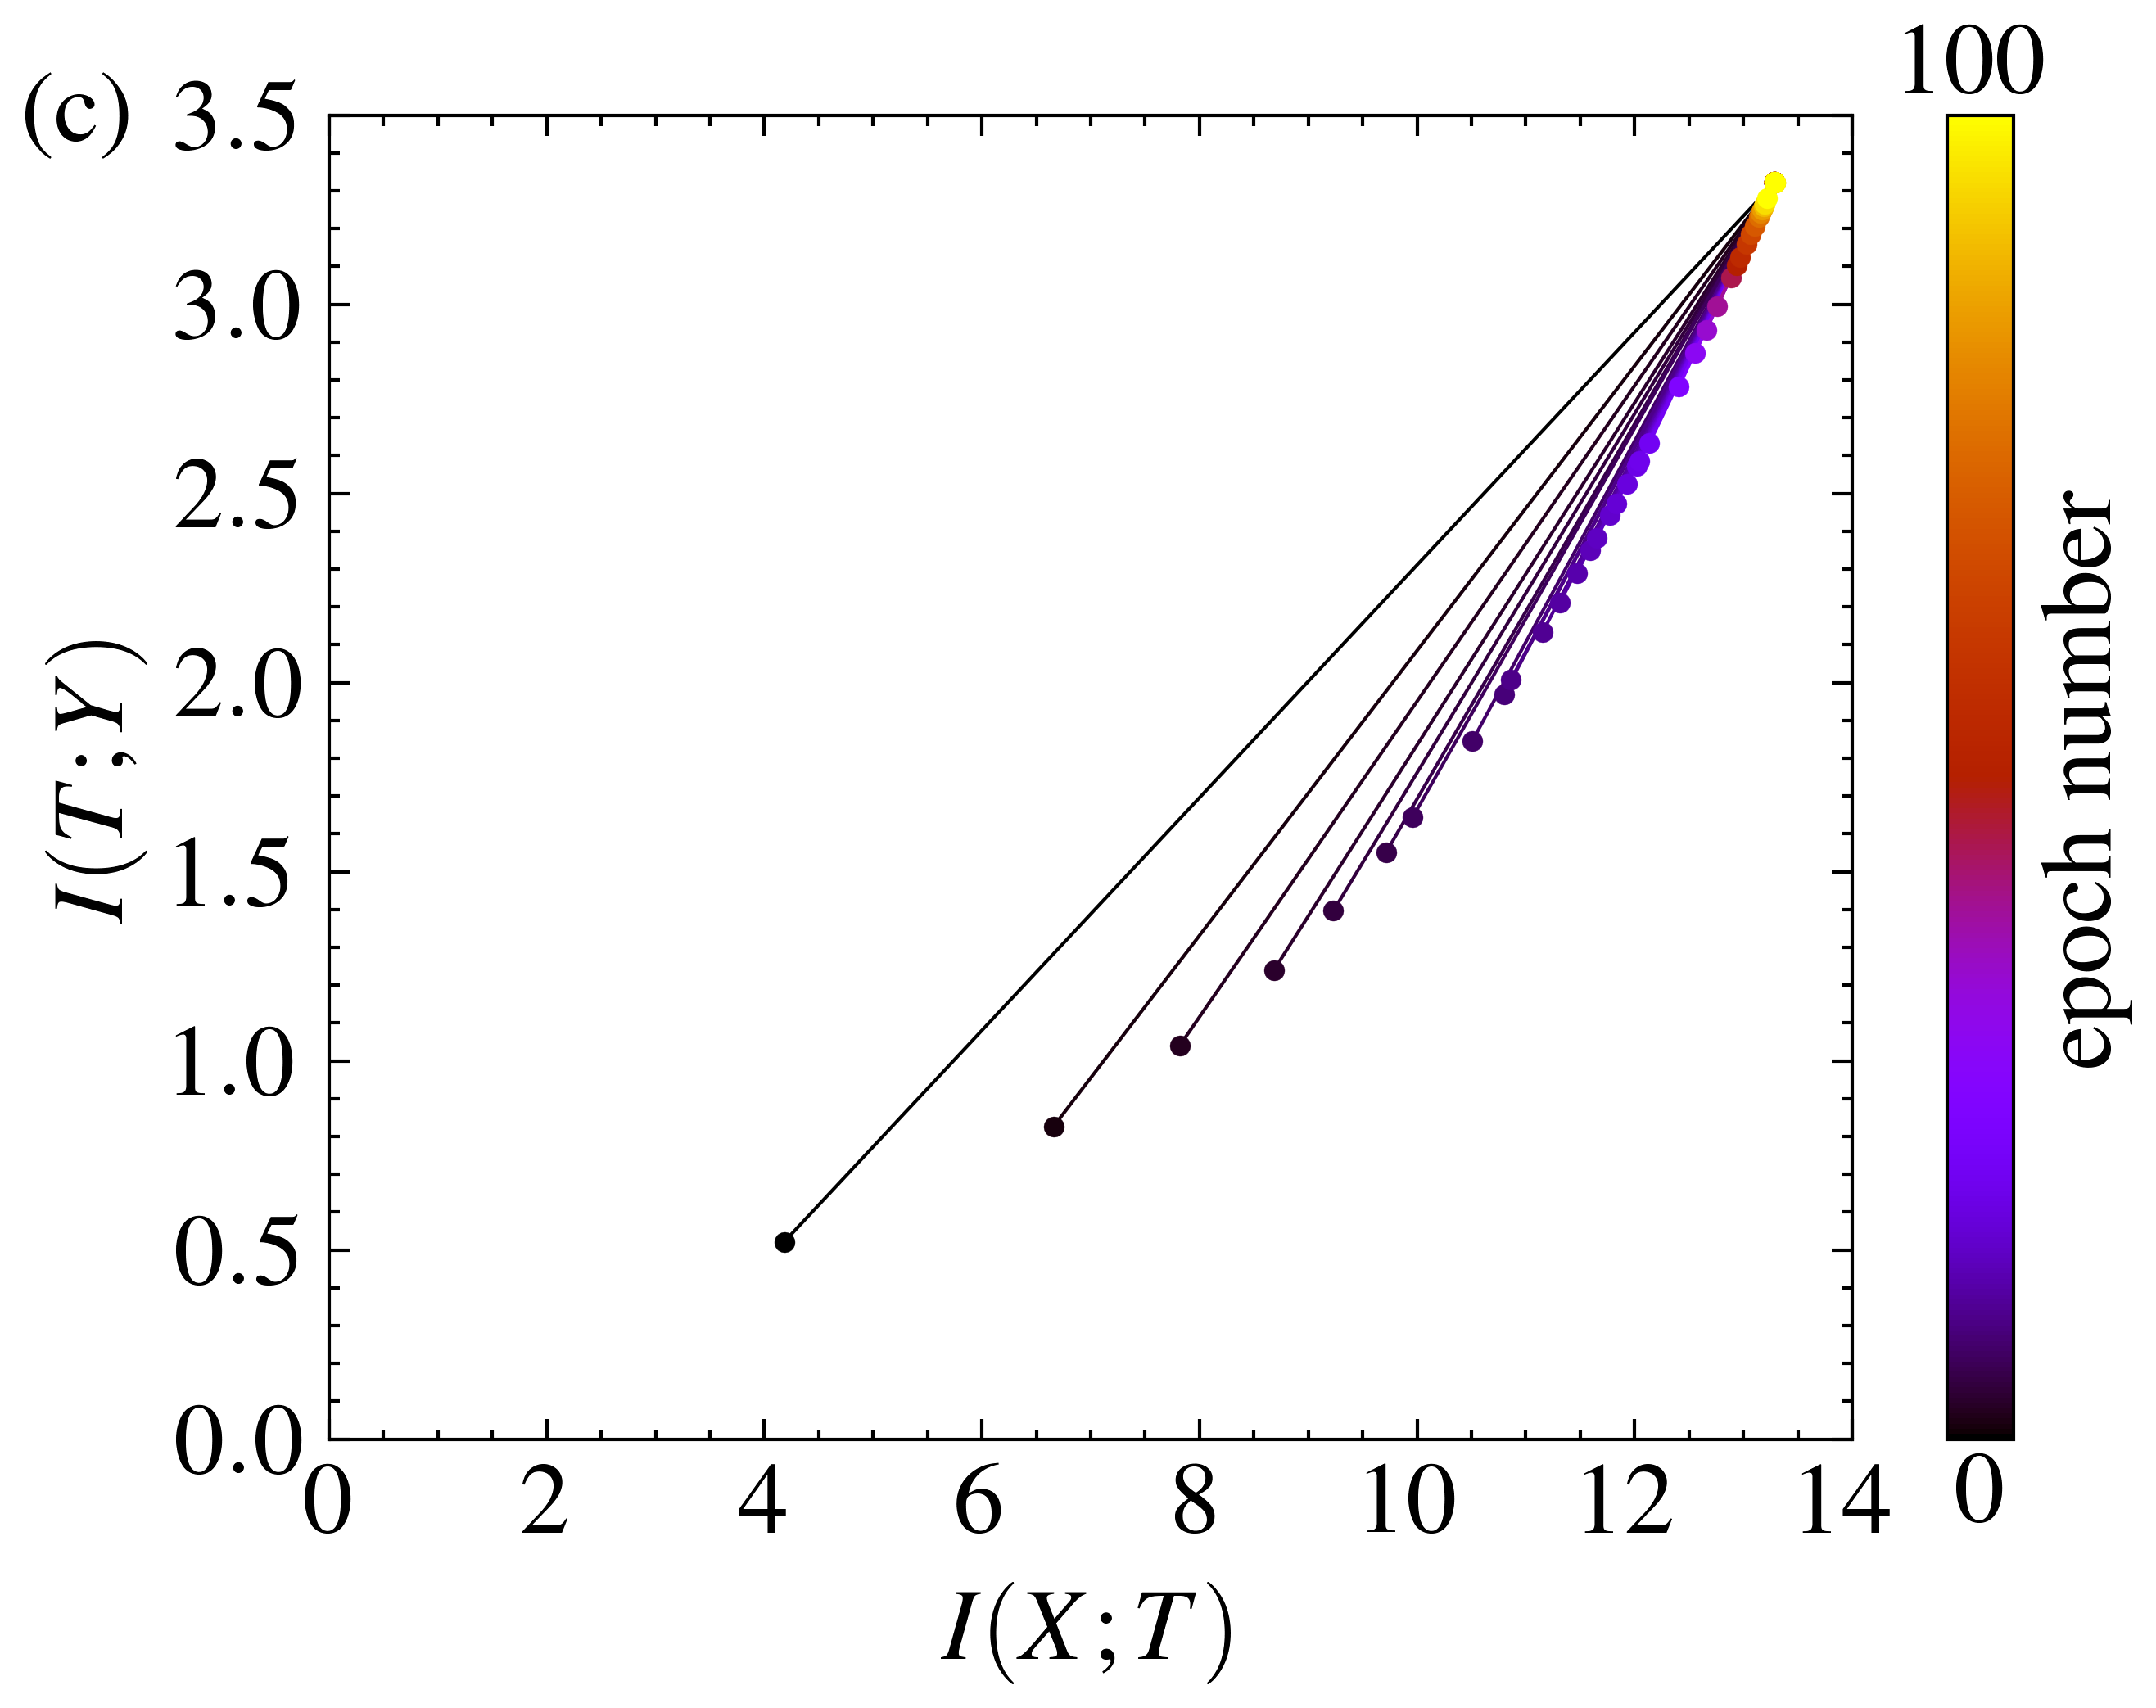

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(0.0, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(c)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/2023年研究生文件/Fig9c.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/2023年研究生文件/MI_XMGELU.npy', allow_pickle=True)
ITY_array = np.load('D:/2023年研究生文件/MI_YMGELU.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [42]:
import kde
import simplebinmi
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from collections import OrderedDict
from collections import defaultdict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 检查 GPU 是否可用
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超参数
batch_size = 128 # Reduce batch size

# 数据变换
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Add horizontal flip
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载数据集
train_data = datasets.CIFAR10(root='./data/', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor())

# 数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
full_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

import math

class SiLU(nn.Module): 
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.5))  # 可学习参数 sigma

    def forward(self, input):
        #x = input * (1 + torch.erf(input / math.sqrt(2) / self.sigma)) / 2
        x = input*torch.sigmoid(input/self.sigma)#SiLU
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Net, self).__init__()
        
        # One convolutional layer followed by batch normalization and ReLU
        self.conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)  # 3x3 kernel, 32 filters
        self.bn = nn.BatchNorm2d(32)
        self.silu1 = SiLU()
        self.silu2 = SiLU()

        # Pooling layer
        self.avg_pool = nn.AvgPool2d(2)  # 2x2 pooling to reduce spatial size

        # Linear layers
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Flattened size after pooling (32*16*16)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        activations = []
        
        # Convolutional Layer 1
        out = self.conv(x)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        out = self.bn(out)
        out = self.silu1(out)
       
        # Pooling Layer
        out = self.avg_pool(out)
        xx = torch.flatten(out, 1)
        activations.append(xx.cpu().data.numpy())
        
        # Flatten before feeding into fully connected layer
        out = out.view(out.size(0), -1)  # Flatten the tensor (batch_size, 32 * 16 * 16)
        
        # Fully Connected Layer 1
        out = self.fc1(out)
        out = self.silu2(out)
        
        # Fully Connected Layer 2
        out = self.fc2(out)
        
        activations.append(out.cpu().data.numpy())  # Store final activations
        
        return out, activations

CUDA is available! Training on GPU ...
Files already downloaded and verified


In [43]:
class MI_Plate():
    def __init__(self, n_epochs=102, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS

    def save_activations(self):
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net(in_channels=3, n_classes=10)
        #model.apply(init_weights)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()

        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                #loss = categorical_cross_entropy(output, target)
                loss = loss_fn(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch + 1, train_loss))

            model.eval()

            ######### 每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出 ###########
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
            ############################################################################################
            
            # Log activations for different epochs
            if epoch < 20:
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 100) and (epoch % 5 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):
                fname = 'activations' + "/epoch%08d" % epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)

            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))                  
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array, dtype=object)
        MI_YM_upper_array = np.array(MI_YM_upper_array, dtype=object)

    # Save the results as arrays
        np.save('D:/2023年研究生文件/MI_XMSiLU.npy', MI_XM_upper_array)
        np.save('D:/2023年研究生文件/MI_YMSiLU.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)   

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.016813
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 12.76%
Epoch: 2 	Training Loss: 0.015383
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 15.19%
Epoch: 3 	Training Loss: 0.014610
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 18.45%
Epoch: 4 	Training Loss: 0.014095
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 17.98%
Epoch: 5 	Training Loss: 0.013676
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 18.10%
Epoch: 6 	Training Loss: 0.013354
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 19.16%
Epoch: 7 	Training Loss: 0.013089
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 20.73%
Epoch: 8 	Training Loss: 0.012829
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 19.89%
Epoch: 9 	Training Loss: 0.012611
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 20.12%
Epoch: 10 	Training Loss: 0.012418
Saving acti

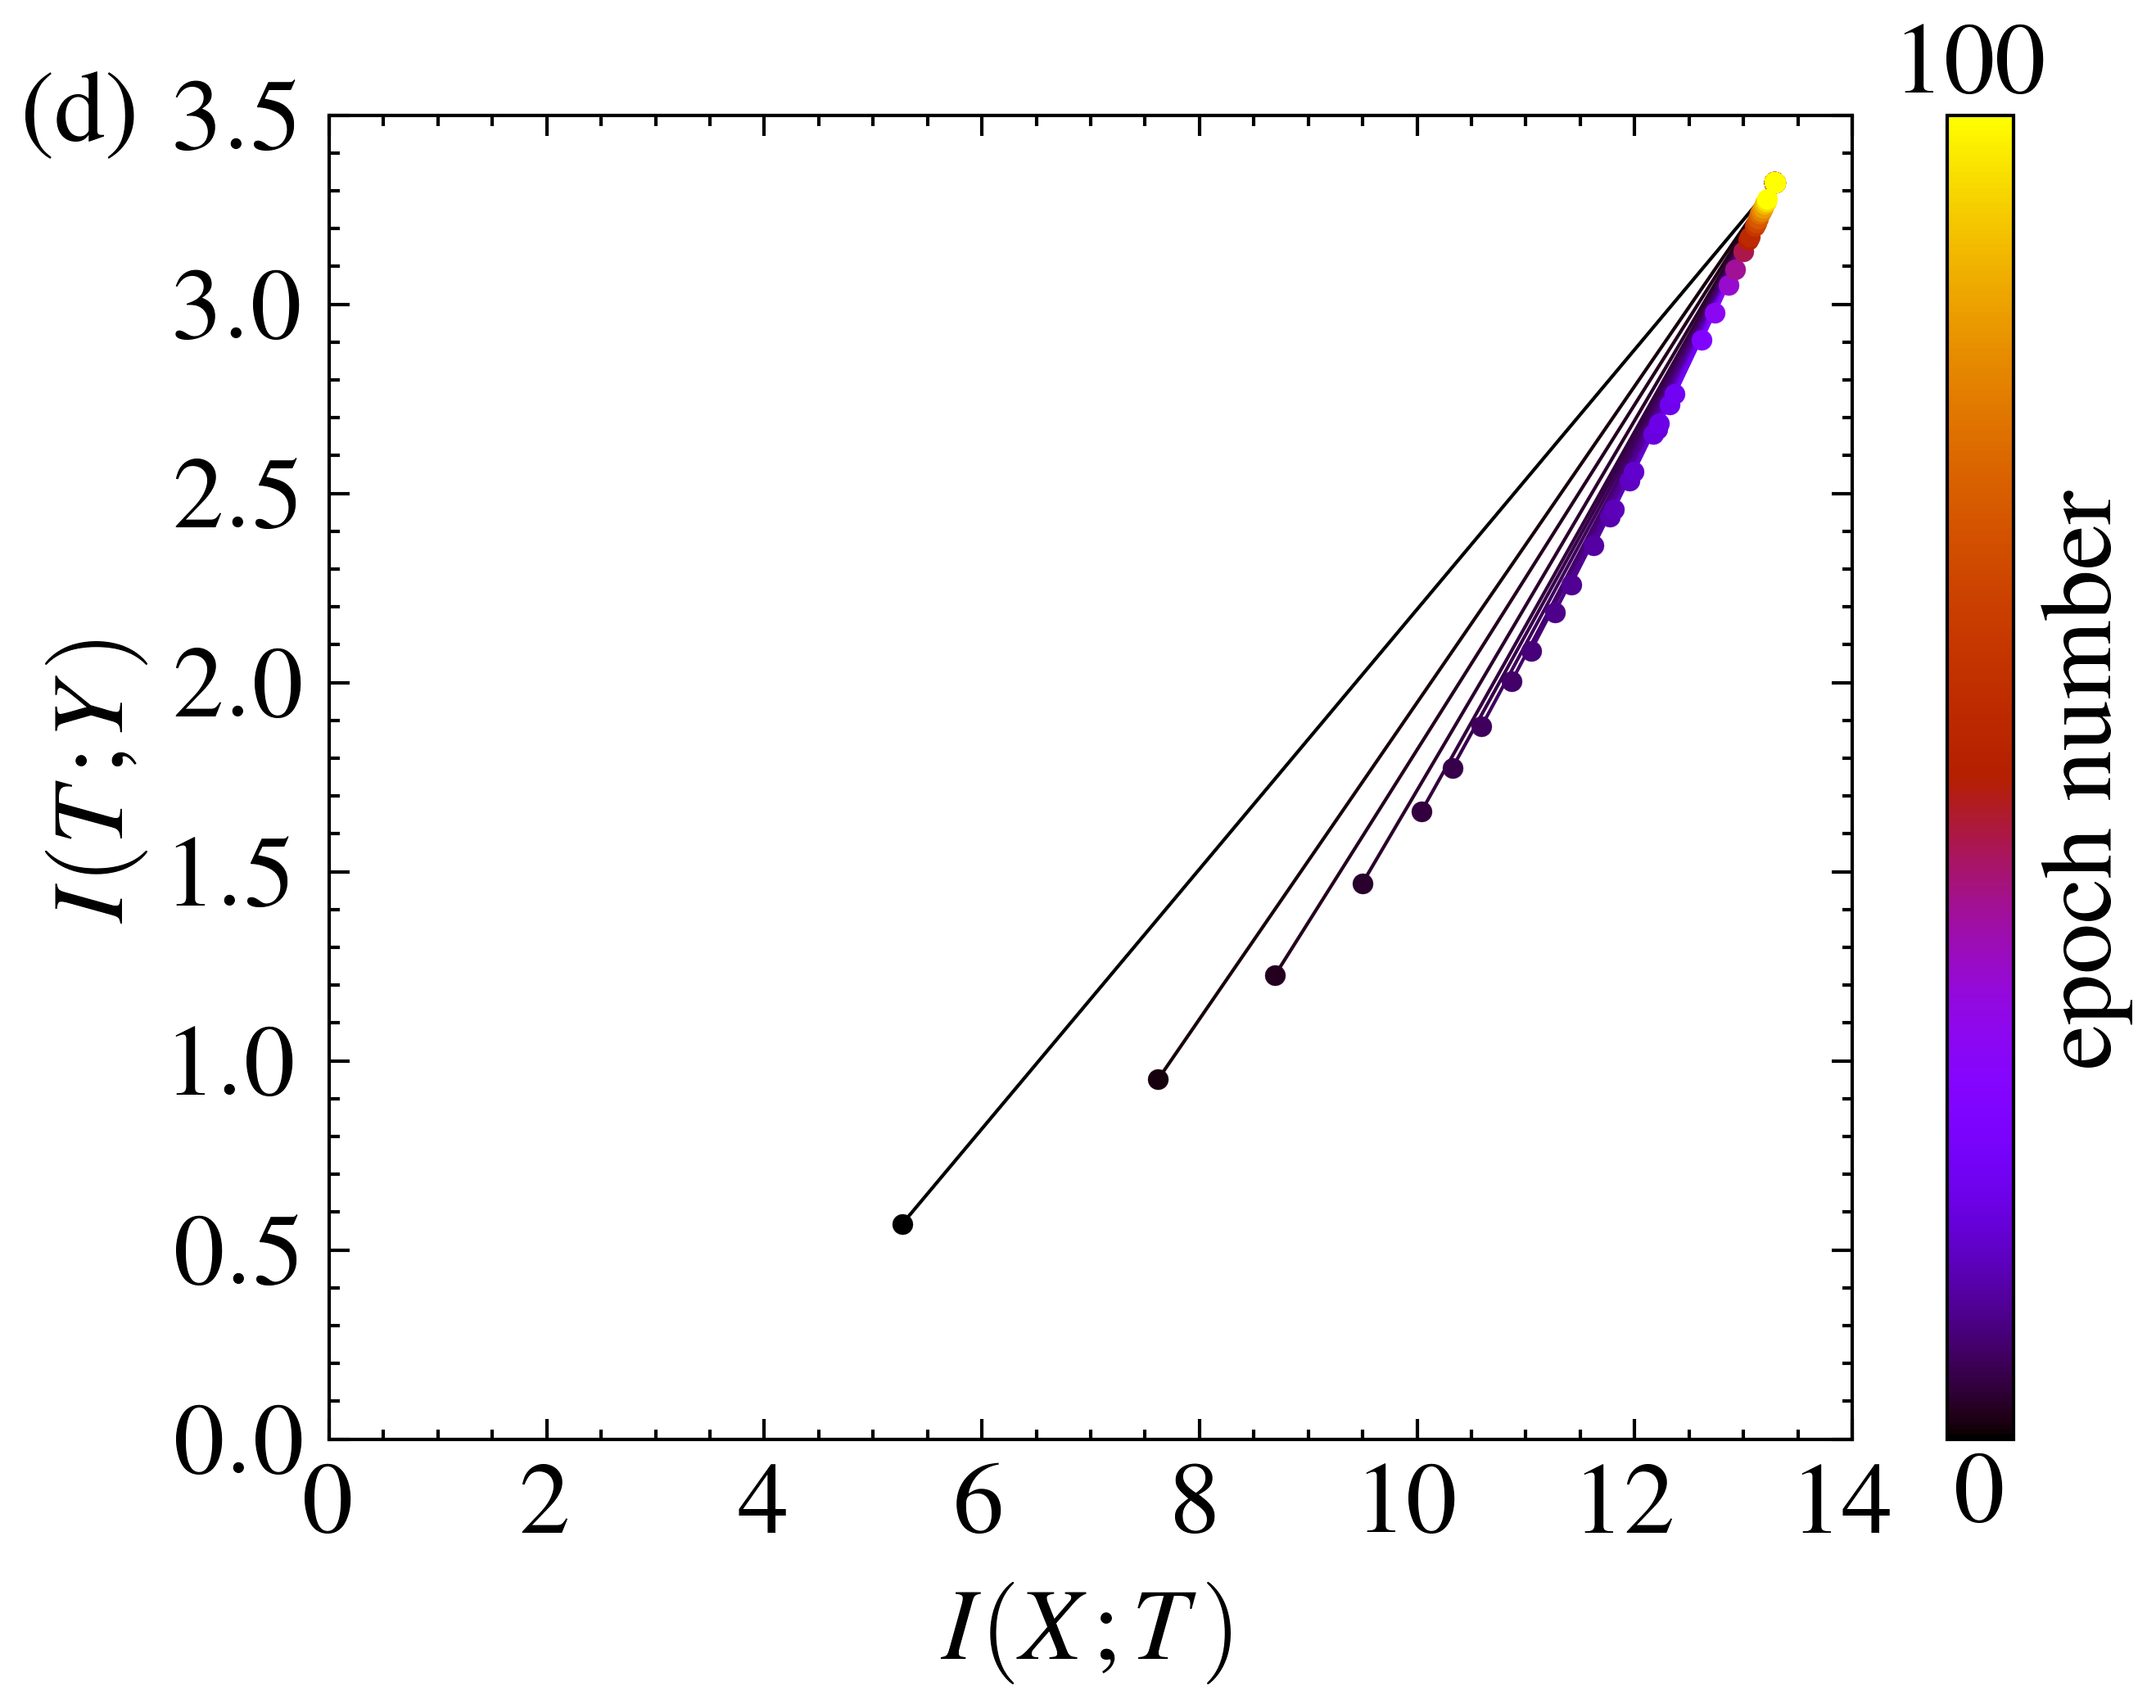

In [44]:
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(0.0, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(d)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/2023年研究生文件/Fig9d.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/2023年研究生文件/MI_XMSiLU.npy', allow_pickle=True)
ITY_array = np.load('D:/2023年研究生文件/MI_YMSiLU.npy', allow_pickle=True)

plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [10]:
accuracyReLU = np.array([
    10.53, 14.21, 16.41, 17.68, 18.40, 20.08, 19.19, 20.18, 21.26, 20.74, 
    23.23, 23.51, 22.81, 22.98, 24.36, 24.25, 25.23, 24.24, 25.66, 26.45, 
    26.00, 25.85, 25.19, 26.31, 27.02, 27.64, 25.83, 27.26, 28.15, 27.69, 
    28.61, 26.30, 27.46, 27.76, 27.28, 29.78, 28.62, 27.26, 30.37, 29.25, 
    30.33, 29.25, 30.31, 31.04, 32.68, 28.44, 29.50, 31.58, 27.51, 28.31, 
    30.89, 31.87, 29.96, 32.56, 32.12, 34.50, 32.06, 33.49, 30.93, 32.34, 
    34.25, 33.91, 34.29, 34.72, 35.73, 33.44, 34.30, 33.90, 32.58, 36.74, 
    37.80, 35.38, 33.33, 37.64, 33.87, 35.88, 31.64, 34.37, 38.55, 37.41, 
    35.29, 35.97, 39.45, 37.95, 36.68, 35.38, 37.66, 33.04, 38.36, 33.37, 
    36.55, 39.84, 36.88, 38.60, 34.27, 39.98, 39.01, 38.56, 40.82, 37.85, 
    37.72, 34.93
])

accuracyG = np.array([
    10.43, 13.66, 16.22, 16.36, 17.69, 19.59, 21.06, 20.99, 21.23, 21.75, 
    22.04, 21.30, 23.92, 23.09, 24.28, 24.65, 25.71, 26.05, 25.03, 24.85, 
    26.45, 25.69, 26.05, 27.07, 27.23, 26.62, 28.09, 27.53, 27.84, 27.65, 
    27.09, 28.52, 27.56, 28.44, 28.79, 26.95, 29.97, 30.52, 29.67, 30.88, 
    29.65, 30.89, 29.23, 30.95, 31.24, 31.20, 30.29, 31.61, 30.92, 33.81, 
    31.81, 33.60, 32.69, 33.23, 33.50, 31.99, 33.42, 35.02, 34.50, 35.82, 
    32.43, 34.17, 35.26, 36.56, 36.29, 37.01, 35.15, 34.60, 37.44, 37.25, 
    38.14, 36.28, 37.84, 36.06, 39.42, 37.20, 38.60, 37.39, 38.28, 39.93, 
    37.60, 38.10, 38.72, 40.44, 38.72, 38.03, 36.84, 37.49, 38.76, 39.19, 
    34.36, 39.99, 41.54, 40.54, 38.43, 41.85, 40.71, 42.69, 43.03, 41.27, 
    42.00, 39.63
])

accuracyS = np.array([
    12.76, 15.19, 18.45, 17.98, 18.10, 19.16, 20.73, 19.89, 20.12, 22.06, 
    21.93, 20.74, 22.47, 20.78, 22.87, 23.59, 23.04, 24.12, 25.37, 24.42, 
    24.04, 25.54, 25.31, 26.83, 27.15, 25.78, 26.28, 28.67, 27.71, 26.20, 
    26.22, 28.64, 28.91, 28.92, 29.12, 29.62, 30.09, 30.37, 29.65, 28.63, 
    29.90, 30.37, 30.13, 30.31, 31.48, 31.37, 32.36, 29.82, 32.74, 32.52, 
    30.93, 32.76, 32.78, 31.59, 32.88, 33.86, 34.20, 32.52, 35.22, 35.24, 
    34.93, 36.07, 35.52, 32.29, 34.22, 33.99, 39.55, 37.30, 35.76, 36.35, 
    35.61, 35.05, 33.57, 33.62, 36.22, 35.18, 36.14, 36.21, 36.24, 34.77, 
    39.22, 37.86, 38.41, 39.66, 39.97, 37.71, 37.51, 38.20, 38.08, 39.77, 
    36.31, 37.61, 42.02, 36.00, 36.76, 42.52, 38.07, 40.10, 39.65, 36.58, 
    37.88, 38.67
])

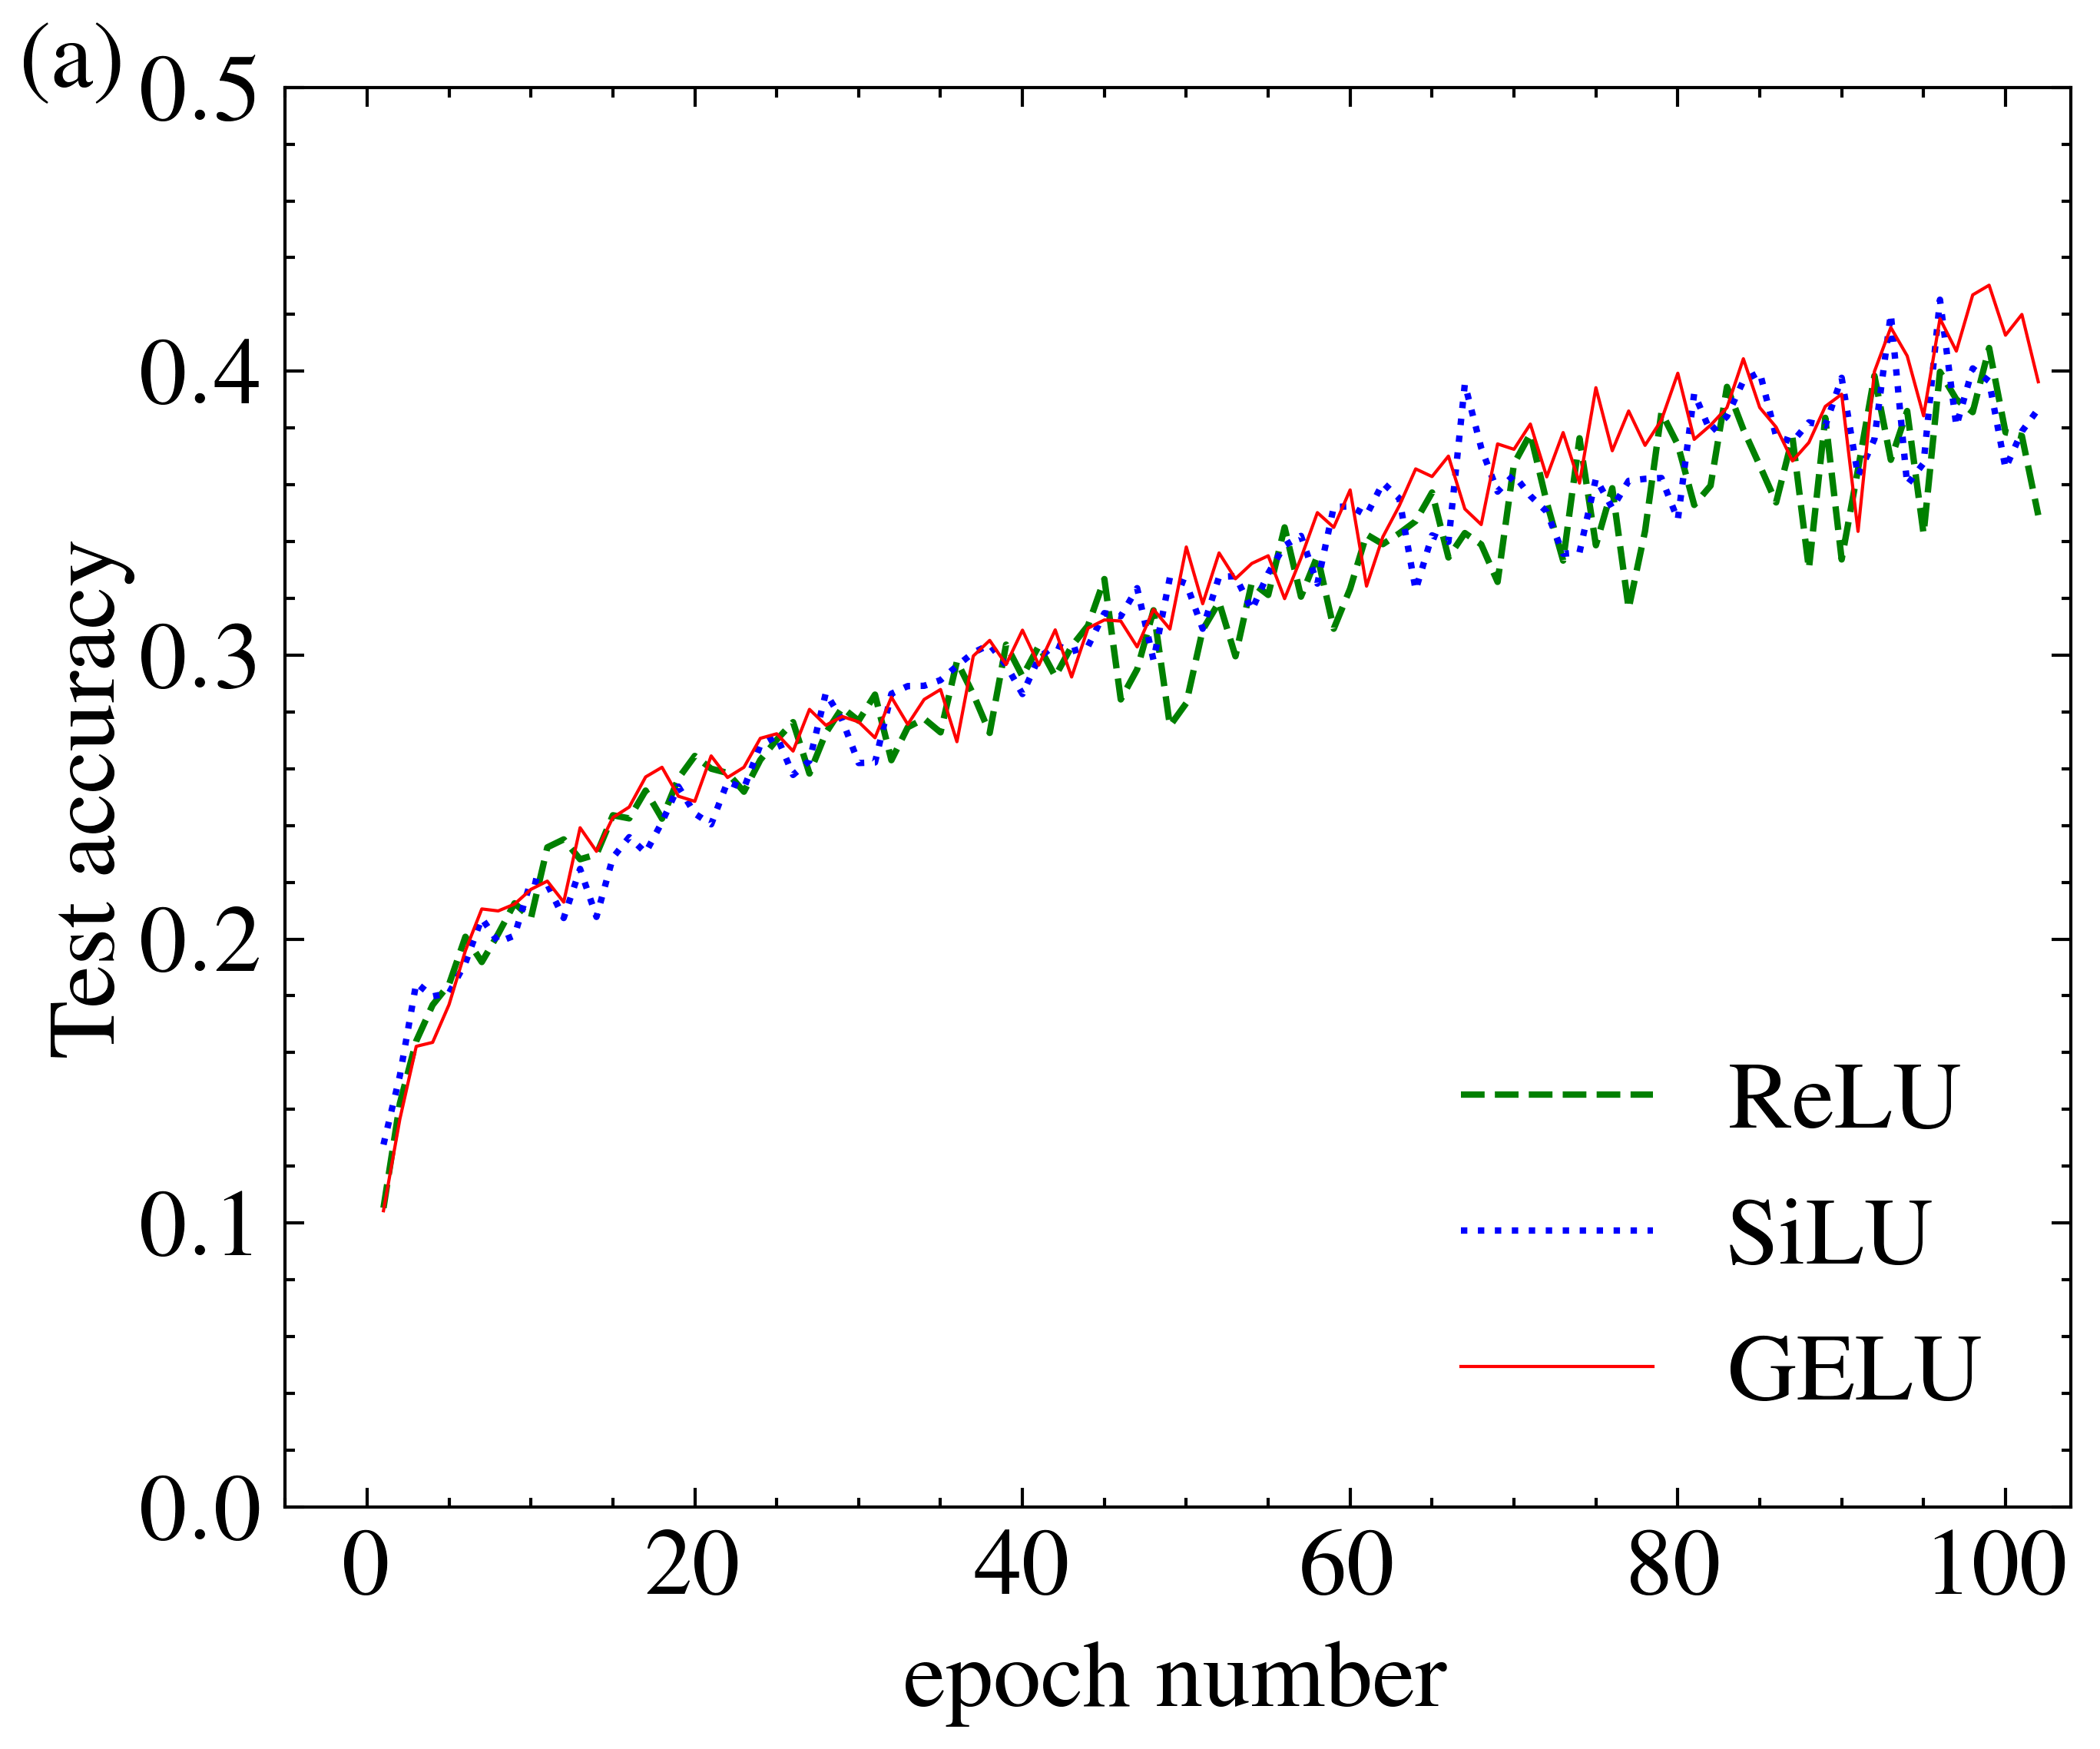

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
plt.style.use(['science','ieee'])

fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"Test accuracy", fontsize=15, labelpad=1)
ax.set_xlim(-5, len(accuracyReLU)+2)  # Adjust x-axis limits to start from epoch 1
ax.set_ylim(0.0, 0.5)

# Create the x-axis array to represent epoch numbers
epochs = np.arange(1, len(accuracyReLU)+1)

# Plot the accuracy curves
ax.plot(epochs, 0.01*accuracyReLU, 'g--', lw=1, label=r"ReLU")
ax.plot(epochs, 0.01*accuracyS, 'b:', lw=1, label=r"SiLU")
ax.plot(epochs, 0.01*accuracyG, 'r-', lw=0.5, label=r"GELU")

ax.text(-21, 0.5, '(a)', fontdict={'size': 15, 'color': 'black'})
ax.legend(loc='lower right', fontsize=15)

#patch = mpl.patches.Rectangle((0.1,0),0.8,5,linewidth=1,linestyle='--',edgecolor='gray',facecolor='none')
#ax.add_patch(patch)
# left, bottom, width, height = [0.3, 0.2, 0.57, 0.3]
# ax2 = fig.add_axes([left, bottom, width, height])

# step = np.arange(0,101)
# ax2.plot(step[0:5], 0.01*accuracyReLU[0:5], 'g--', marker='*',label=r"ReLU")
# ax2.plot(step[0:5], 0.01*accuracyS[0:5], 'b:', marker='o',label=r"SiLU")
# ax2.plot(step[0:5], 0.01*accuracyG[0:5], 'r-', marker='^',label=r"GELU")
# ax2.set_yticks([0.70,0.75,0.80,0.85,0.90,0.95])

# ax2.tick_params(labelsize=12)
# ax2.legend(loc='lower right', fontsize=12)
plt.show()

fig.savefig('D:/2023年研究生文件/Fig9a.eps', dpi=800)